# Modeling the COVID-19 spread

In [3]:
from functools import lru_cache
from random import randint, random, uniform
import datetime

import pandas as pd
import numpy as np
from statsmodels.nonparametric.kernel_regression import KernelReg
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import tqdm

## The model

We model the spread of the disease in the following manner. The disease may be transmitted from those who are already sick $S_t$, to those that are "well" $W_t$, or susceptible to the disease. The rate of transmission/infection is determined by the number of sick people who a "well" person is in contact with on a daily basis $\bar{N}_{s,t}$, and the individual probability of infection $p_i$. Once a patient has become sick, their sickness lasts for a fixed period $T$, and at the end of this period, they either recover and become immune $I_t$, or die $D_t$. In mathematical terms, it is described by the following discrete time model:

$$
\begin{align}
S_t &= S_{t-1} + \dot{S}_{t} - \dot{S}_{t-T} \qquad \text{(number of sick people)} \\
\dot{S}_t &= RI_{t-1} W_{t-1} \qquad \text{(number of people infected at time $t$)} \\
W_t &= W_{t-1} - \dot{S}_{t} \qquad \text{(number of 'well' people; haven't got sick yet but don't have immunity)} \\
RI_t &= 1 - (1 - p_i)^{\bar{N}_{s,t}} \qquad \text{(rate/probability of infection)} \\
\bar{N}_{s,t} &= \bar{N} (1-q) S_t / P_0 \qquad \text{(avg. # of sick people in contact with daily)} \\
I_t &= I_{t-1} + (1-p_D) \dot{S}_{t-T} \qquad \text{(number of people with immunity)} \\
D_t &= D_{t-1} + p_D \dot{S}_{t-T} \qquad \text{(number of people dead)}
\end{align}
$$

Where we define parameters $T$ = "duration of sickness", $p_i$ = "probability of infection", $p_D$ = "probability of death", $q$ = "fraction of sick quarantined", $\bar{N}$ = "avg. # of people in contact with daily (in absence of epidemic)", and $P_0$ = "initial (total) population". There are also boundary/initial conditions that must be specified. We define $S_0$ = "initial number sick", $f_{imm}$ = "initial fraction of population immune", such that

$$
\begin{align}
S_t &= S_0 \exp(t/T); \quad t = 0, -1, \cdots, -T \\
\dot{S}_t &= S_t - S_{t-1}; \quad t = 0, -1, \cdots, -(T-1) \\
\dot{S}_{-T} &= 0 \\
W_0 &= (P_0 - S_0) (1 - f_{imm}) \\
I_0 &= (P_0 - S_0) f_{imm} \\
D_0 &= 0
\end{align}
$$

## Numerical solution

In [23]:
def model(*, T: int, pi: float, pD: float, q: float, Nbar: float, P0: float, S0: float, f_imm: float):
    """
    Arguments:
        T (int): duration of sickness
        pi (float): probability of infection; 0 <= pi <= 1
        pD (float): probability of death; 0 <= pD <= 1
        q (float): fraction of sick quarantined; 0 <= q <= 1
        Nbar (float/int): avg # of people in daily contact with
        P0 (float/int): initial (total) population
        S0 (float/int): initial # of sick
        f_imm (float): fraction of population with initial immunity; 0 <= f_imm <= 1
    Returns:
        W(t) (func): number of well people
        S(t) (func): number of sick people
        I(t) (func): number of immune people
        D(t) (func): number of dead people
        Sdot(t) (func): number of people infected on day t
        RI(t) (func): rate of infection on day t
    """

    # Define functions

    @lru_cache(maxsize=None)
    def S(t):
        if t < -T:
            raise ValueError
        elif t <= 0:
            return S0*np.exp(t/T)
        return S(t-1) + Sdot(t) - Sdot(t-T)

    @lru_cache(maxsize=None)
    def Sdot(t):
        if t < -T:
            raise ValueError
        elif t == -T:
            return 0
        elif t <= 0:
            return S(t) - S(t-1)
        return RI(t-1) * W(t-1)

    @lru_cache(maxsize=None)
    def W(t):
        if t < 0:
            raise ValueError
        elif t == 0:
            return (P0 - S0) * (1 - f_imm)
        return W(t-1) - Sdot(t)

    def RI(t):
        NbarS = Nbar * (1-q) * S(t) / P0
        return 1 - (1 - pi)**NbarS

    @lru_cache(maxsize=None)
    def I(t):
        if t < 0:
            raise ValueError
        elif t == 0:
            return (P0 - S0) * f_imm
        return I(t-1) + (1-pD) * Sdot(t-T)

    @lru_cache(maxsize=None)
    def D(t):
        if t <= 0:
            return 0
        return D(t-1) + pD * Sdot(t-T)
    
    return W, S, I, D, Sdot, RI

## Application to influenza-like disease

In order to test this model, we will try it out using parameters for a disease similar to the flu. From some quick searching, I found that the flu usually is asymptomatic for 1-4 days, and symptomatic for 5-7, for a total duration of 6-11 days [[source]](https://www.health.harvard.edu/staying-healthy/how-long-does-the-flu-last) (average 8.5 days). Flu vaccination coverage in the 2017-2018 season was about 37.1% [[source]](https://www.cdc.gov/flu/fluvaxview/coverage-1718estimates.htm), so roughly that many people have a starting immunity. The estimated number of people who contracted the flu was 44.8M, and the number that died from it was 61k [[source]](https://www.cdc.gov/flu/about/burden/2017-2018.htm), for an overall probability of death of 0.14%. The population of the United States in 2017 was 326M, and most adult-aged people are normally in close contact with a little over 20 people/day [[source]](https://www.researchgate.net/figure/Daily-average-number-of-contacts-per-person-in-age-group-j-The-average-number-of_fig2_228649013). Shockingly, roughly 25% of Americans either don't recieve sick days off or don't use them at all, and the another 40-60% only use them sparingly [[source]](https://farahandfarah.com/studies/sick-days-in-america/) (based on this, and the fact that the flu is asymptomatic for roughly 1/3 of its duration, I'll assume roughly 50% of people appropriately self-quarantine when sick then).

As for the other parameters ($p_i$, $S_0$), I'm just going to assume that we start with about 1000 people infected ($S_0$=1000), and tune $p_i$ until the number of total deaths is within the uncertainty bounds for the 2017-2018 season (46k-95k).

In [24]:
W, S, I, D, _, _ = model(
    T=9, pi=0.020, pD=0.0014, q=0.50, Nbar=20, P0=326e6, S0=1e3, f_imm=0.371)

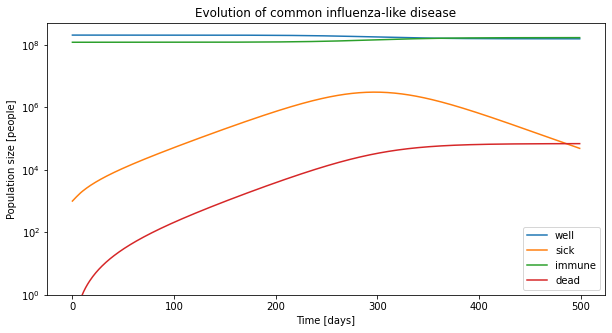

In [25]:
Tmax = 500
fig, ax = plt.subplots(1, figsize=(10, 5))
for func, label in zip([W, S, I, D], ["well", "sick", "immune", "dead"]):
    plt.plot([func(t) for t in range(Tmax)], label=label)
plt.ylim(bottom=1, top=500e6)
plt.xlabel("Time [days]")
plt.ylabel("Population size [people]")
plt.title("Evolution of common influenza-like disease")
plt.legend()
plt.yscale("log")
plt.show()

I find that for a person-to-person infection probability of about $p_i$=2.0%, we end up with about 69k deaths over the course of a year, which is fairly close to the actual number. The number of people sickened by this disease is about 49M, which is within the CDC's uncertainty interval (39M-58M), and at its peak, the number of infected people was 3M and deaths/day is about 500. It seems that these estimates are a little on the high side of things, but they look pretty realistic.

In [26]:
print(f"Total # deaths: {int(D(Tmax)):,}")
print(f"# of people sickened: {int(I(Tmax) - I(0) + S(Tmax) + D(Tmax)):,}")
print(f"Peak # of people infected: {int(max(S(t) for t in range(Tmax))):,}")
print(f"Peak # deaths/day: {int(max(D(t) - D(t-1) for t in range(Tmax))):,}")

Total # deaths: 68,866
# of people sickened: 49,237,633
Peak # of people infected: 3,064,399
Peak # deaths/day: 477


## Application to COVID-19

Now we want to see what the effect of a disease similar to COVID-19 has. Many factors are undetermined at this point, but the main differences between influenza and the coronavirus appear to be:

* The duration of the disease is much longer. Symptoms don't appear until 2-14 days after exposure [[source]](https://www.cdc.gov/coronavirus/2019-ncov/about/symptoms.html)
* The duration of symptoms is much harder to ascertain, but 1-2 weeks seems to be the rule of thumb
* The disease is much more deadly; the WHO estimates that 3.4% of cases have died thus far [[source]](https://www.who.int/dg/speeches/detail/who-director-general-s-opening-remarks-at-the-media-briefing-on-covid-19---3-march-2020)
* Since this disease is caused by a _novel_ coronavirus, no one has any natural immunity
* It _appears_ to be more easily transmissible than the flu
* Because of the large media attention, it is likely that more people will choose to self-quarantine, or take preventative measures to avoid interacting with others
    * However, because of the 2-14 day incubation period before symptoms appear, patients could go much longer periods of time before realizing they should self-quarantine

Based on these observations, I will use the following model parameters:

In [41]:
W, S, I, D, _, _ = model(
    T=15, pi=0.03, pD=0.034, q=0.5, Nbar=10, P0=326e6, S0=1300, f_imm=0)

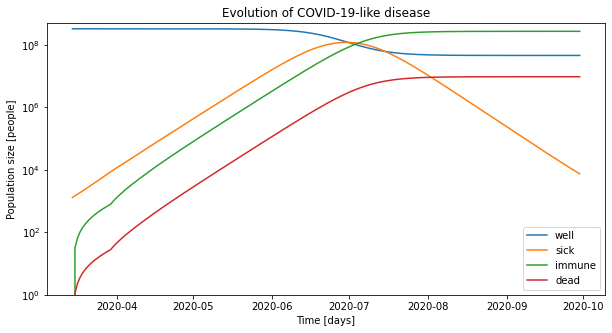

In [42]:
Tmax = 200
today = datetime.datetime.now()
days = pd.date_range(today, today + pd.Timedelta(Tmax-1, 'D'))
fig, ax = plt.subplots(1, figsize=(10, 5))
for func, label in zip([W, S, I, D], ["well", "sick", "immune", "dead"]):
    plt.plot(days, [func(t) for t in range(Tmax)], label=label)
plt.ylim(bottom=1, top=500e6)
plt.xlabel("Time [days]")
plt.ylabel("Population size [people]")
plt.title("Evolution of COVID-19-like disease")
plt.legend()
plt.yscale("log")
plt.show()

We can see that the number of sick $S_t$ grows exponentially until the ratio of immune to the total population $I_t/P_0$ becomes significant (~23%), at which point herd immunity starts to suppress new infections. Because we are starting with no immunity and no vaccination, the disease is initially allowed to grow exponentially; unlike the flu, which has a starting immunity of about 40%.

I find that for a slightly larger person-to-person infection probability of about $p_i$=3%, we end up with a staggering 9.5M deaths over the course of the coming months. The number of people sickened by this disease is about 280M, which is just short of the entire population of the United States! At its peak, the number of infected people will be 120M and deaths/day a grueling 290k. All this will occur over the course of the next 5-6 months, with infections peaking in late June or early July. If this is true, the repercussions could be truly horrendous.

In [43]:
print(f"Total # deaths: {int(D(Tmax)):,}")
print(f"# of people sickened: {int(I(Tmax) - I(0) + S(Tmax) + D(Tmax)):,}")
print(f"Peak # of people infected: {int(max(S(t) for t in range(Tmax))):,}")
print(f"Peak # deaths/day: {int(max(D(t) - D(t-1) for t in range(Tmax))):,}")
print(f"Fraction immune/recovered at the peak of infection: {100*I(np.argmax([S(t) for t in range(Tmax)]))/326e6:.1f}%")

Total # deaths: 9,528,659
# of people sickened: 280,261,350
Peak # of people infected: 120,155,924
Peak # deaths/day: 291,066
Fraction immune/recovered at the peak of infection: 23.1%


It should be noted that the exact numbers are highly dependent on the parameters used in the model. For example, if I use a more conservative estimate of $p_i$=2%, the number of deaths falls to 6.5M. If the death rate turns out to be closer to $p_D$=1%, then the number of deaths falls to 2.8M. If people take even further preventative measures and only interact with $\bar{N}$=5 people/day on average, then the deaths fall even further to 1.9M.

## Meta-simulation

I'm going to randomly generate a bunch of parameters and create a simulation for each set, then analyze all the sets from a statistical point of view.

In [9]:
results_df = list()
for _ in tqdm.tqdm(range(100_000)):
    # Specify model parameter priors
    T = randint(5, 30)
    pi = uniform(0, 0.1)
    pD = uniform(0, 0.05)
    q = random()
    Nbar = randint(1, 30)
    f_imm = uniform(0, 0.1)
    W, S, I, D, Sdot, _ = model(
        T=T, pi=pi, pD=pD, q=q, Nbar=Nbar, P0=326e6, S0=1, f_imm=f_imm)
    # Run simulation to completion
    t = 100
    peak_infected, peak_deaths = 0, 0
    t_peak = 0
    while S(t) > 1:
        peak_infected = max(peak_infected, S(t))
        deaths = D(t) - D(t-1)
        if deaths > peak_deaths:
            peak_deaths = deaths
            t_peak = t
        I(t)
        t += 1
    # Save data to dataframe
    results_df.append({
        "duration": T,
        "prob_infection": pi,
        "prob_death": pD,
        "quarantine_frac": q,
        "avg_contacts": Nbar,
        "immune_frac": f_imm,
        "total_deaths": D(t),
        "total_infected": I(t) + S(t) + D(t) - I(0),
        "total_never_infected": W(t),
        "peak_deaths": peak_deaths,
        "peak_infected": peak_infected,
        "t_peak": t_peak,
        "t_max": t
    })
results_df = pd.DataFrame(results_df)

100%|██████████| 100000/100000 [02:59<00:00, 556.48it/s]


In [10]:
results_df.head()

,duration,prob_infection,prob_death,quarantine_frac,avg_contacts,immune_frac,total_deaths,total_infected,total_never_infected,peak_deaths,peak_infected,t_peak,t_max
0,22,0.086007,0.040524,0.883416,30,0.056618,1.244450e+07,3.070885e+08,4.539216e+05,815808.877887,1.055087e+08,100,166
1,8,0.089998,0.040563,0.125583,27,0.049065,1.257470e+07,3.100048e+08,1.364975e+01,0.000000,0.000000e+00,0,100
2,27,0.037348,0.024262,0.180545,25,0.000610,7.904478e+06,3.258011e+08,2.370893e-01,0.000000,0.000000e+00,0,100
3,9,0.041960,0.011170,0.620541,26,0.067392,3.286760e+06,2.942362e+08,9.793894e+06,46.080744,9.264522e+03,100,126
4,18,0.015406,0.014994,0.239510,25,0.049639,4.614664e+06,3.077637e+08,2.054050e+06,292894.690282,1.179410e+08,100,171


The typical number of deaths is fairly large, on the order of 10M. An extremely large fraction of people in the United States will become infected, on the order of 100M ($\sim 30\%$) or more.

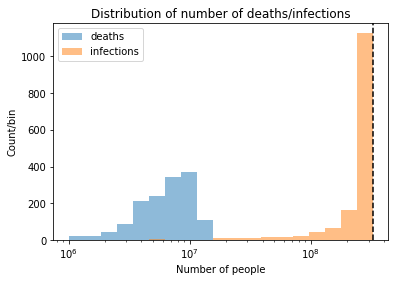

In [13]:
mask = (
    (results_df['immune_frac'] < 0.01)
    & (results_df['prob_death'].between(0.01, 0.04))
    & (results_df['t_peak']>0)
    & (results_df['quarantine_frac'].between(0.5, 0.9))
)
df = results_df[mask]
x = df['total_deaths'].values
bins = np.geomspace(1e6, 326e6, 20)
plt.xscale('log')
# bins = np.linspace(0, 326e6, 100)
# plt.xscale('linear')
plt.hist(x, bins=bins, label='deaths', alpha=0.5)
x = df['total_infected'].values
plt.hist(x, bins=bins, label='infections', alpha=0.5)
plt.axvline(326e6, color='black', linestyle='--')
plt.xlabel("Number of people")
plt.ylabel("Count/bin")
plt.title("Distribution of number of deaths/infections")
plt.legend()
plt.show()

Is there anything that we can do to stop this disease? Most of the model parameters are beyond our control (like $p_D$, $T$, etc.), but some of them can be influenced by public policy and social behavior, such as quarantine effectiveness and limiting contact with other people. Here is how the death rate would change as a function of $q$ and $\bar{N}$:

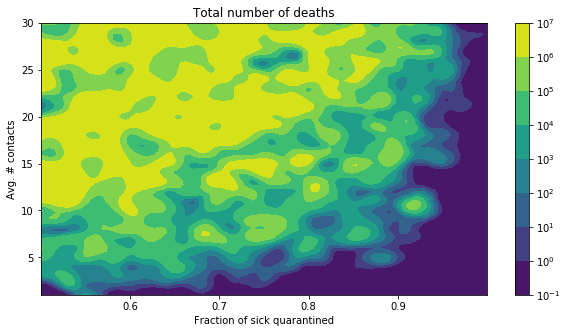

In [15]:
# Get data
mask = (
    (results_df['immune_frac'] < 0.01)
    & (results_df['prob_death'].between(0.01, 0.04))
    & (results_df['quarantine_frac'].between(0.5, 1))
)
x, y, z = results_df[mask][['quarantine_frac','avg_contacts','total_deaths']].values.T
bw = [(xx.max()-xx.min())/50 for xx in [x, y]]
reg = KernelReg(np.log10(z), [x, y], var_type='cc', reg_type='lc', bw=bw)
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
XI, YI = np.meshgrid(xi, yi)
ZI, _ = reg.fit([XI.flatten(), YI.flatten()])
ZI = 10**ZI.reshape(XI.shape)
ZI[ZI<1] = 0.1

# Make figures
fig = plt.figure(figsize=(10, 5))
levels = [10**n for n in range(-1, 8)]
plt.contourf(XI, YI, ZI, levels=levels, norm=colors.LogNorm())
# plt.scatter(x, y, c=z, s=15, alpha=1, zorder=10, edgecolor='black', norm=colors.LogNorm())
cbar = plt.colorbar()
plt.xlim(left=x.min(), right=x.max())
plt.ylim(bottom=y.min(), top=y.max())
plt.xlabel("Fraction of sick quarantined")
plt.ylabel("Avg. # contacts")
plt.title("Total number of deaths")
plt.show()

We can see that the best possible course of action is to institute a strong quarantine of the sick ($q > 90\%$), but I belive this is incredibly unlikely considering the lack of testing kits, long period of asymptomatic infection, inability of most Americans to take sick days off work, and lackluster government response thus far. It is probably more feasible at this point to intentionally limit your contact with others ($\bar{N} > 5$). You should definitely not attend any large gatherings/festivals/events.

## Conclusion

Based on the above analysis, it seems that COVID-19 will be much more deadly overall than the seasonal flu. It appears that the only way to avoid millions of deaths is to take extreme preventative/quarantine measures, and severely limit your contact with others. Work from home if possible until the disease has been contained. Unfortunately for most Americans, sick leave is either inflexible or nonexistent, and this will greatly hamper quarantine efforts once the virus has spread to a sizable fraction of the population.

It should be once again stressed that I am not an epidemiologist; I don't have any formal training in modeling the spread of diseases. I have tried to make these calculations as realistic as possible, but cannot guarantee their accuracy in any way. Please listen to any directions from the CDC or WHO, and try not to panic.